# 🔍 Predicting Item Prices from Descriptions (Part 5)
---
-  Data Curation & Preprocessing
- Model Benchmarking – Traditional ML vs LLMs
- E5 Embeddings & RAG
- Fine-Tuning GPT-4o Mini
- ➡️ Evaluating LLaMA 3.1 8B Quantized
- Fine-Tuning LLaMA 3.1 with QLoRA
- Evaluating Fine-Tuned LLaMA
- Summary & Leaderboard

---

# 🦙 Part 5: Evaluating LLaMA 3.1 8B Quantized

- 🧑‍💻 Skill Level: Advanced
- ⚙️ Hardware: ⚠️ GPU required - use Google Colab
- 🛠️ Requirements: 🔑 HF Token
- Tasks:
    - Quantize LLaMA 3.1 8B to 4-bit
    - Define prediction function
    - Evaluate with Tester

We know LLaMA 3.1 won’t beat frontier models — but how far behind is it without any tuning?

---
📢 Find more LLM notebooks on my [GitHub repository](https://github.com/lisekarimi/lexo)

In [ ]:
# Install required packages in Google Colab
%pip install -q datasets torch transformers bitsandbytes accelerate matplotlib

In [ ]:
#  imports

import re
import math
import torch
from huggingface_hub import login
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, set_seed
from google.colab import userdata
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Google Colab User Data
# Ensure you have set the following in your Google Colab environment:
hf_token = userdata.get('HF_TOKEN')

In [ ]:
# Constants

BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
HF_USER = "lisekarimi"
DATASET_NAME = f"{HF_USER}/pricer-data"

login(hf_token, add_to_git_credential=True)

## 📥 Load Dataset

In [ ]:
# #If you face NotImplementedError: Loading a dataset cached in a LocalFileSystem is not supported run:
# %pip install -U datasets

In [ ]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

In [ ]:
test[0]

## 🦙 Load Tokenizer and Quantized LLaMA Model

A quick reminder of how padding for batch processing works:

`texts = ["I love AI", "AI is"]`

If you tokenize them without padding, you get:
```
['I', 'love', 'AI'] → length = 3
['AI', 'is'] → length = 2
```
❗ Models require equal-length inputs for batching.

Set padding like this:
```
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"
tokens = tokenizer(texts, padding=True, return_tensors="pt")
```

Result:
```
['I', 'love', 'AI'] → [Token1, Token2, Token3]
['AI', 'is', '<eos>'] → [Token1, Token2, PAD]
```
Now both sequences are the same length (3) → batch-ready.


In [ ]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:.1f} GB")

## 🤖 Prediction

In [ ]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','').replace('$','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [ ]:
def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = base_model.generate(inputs, max_new_tokens=4, attention_mask=attention_mask, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [ ]:
model_predict(test[0]['text']), test[0]['price']

## 🧪 Run Evaluation

In [ ]:
# Helper class for evaluating model predictions

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

class Tester:

    def __init__(self, predictor, data, title=None, size=100):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        # title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        # print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        # max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)

        # Add color legend
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Accurate (green)', markerfacecolor='green', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Medium error (orange)', markerfacecolor='orange', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='High error (red)', markerfacecolor='red', markersize=8)
        ]
        plt.legend(handles=legend_elements, loc='upper right')

        plt.show()


    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

In [ ]:
Tester.test(model_predict, test)

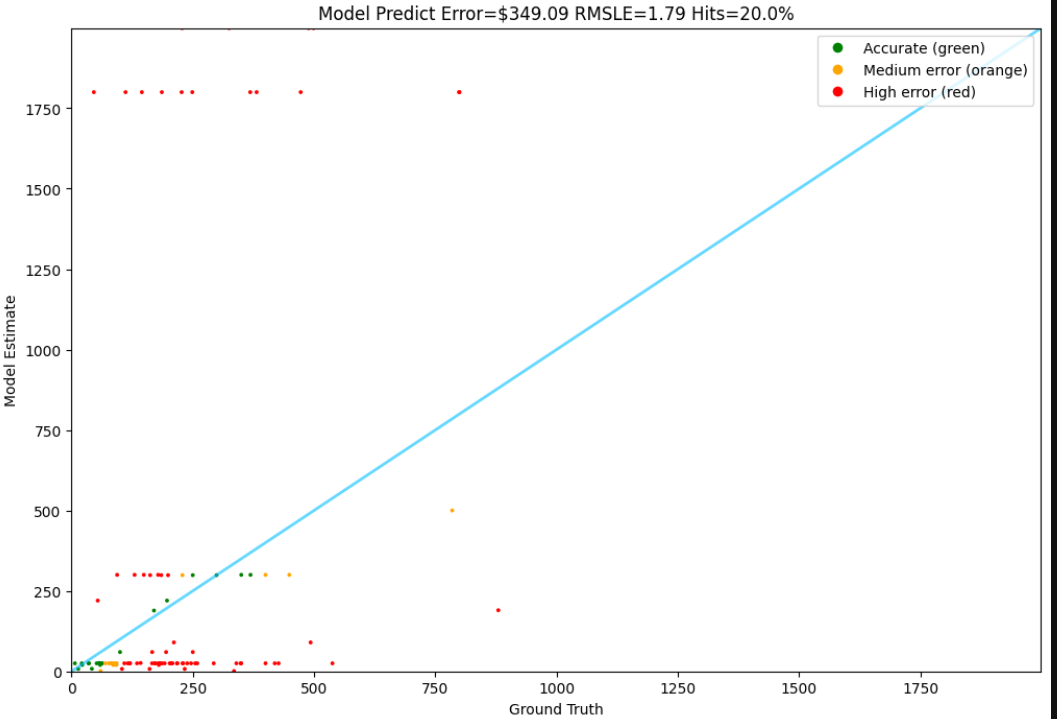

Alright — now that we know where things stand, it’s time to shake things up.

Can QLoRA fine-tuning unlock the true power of LLaMA 3.1?

👀 Let’s find out... in the [next notebook](https://github.com/lisekarimi/lexo/blob/main/09_part6_ft_llama_qlora.ipynb)